# <center>Demographics and Comorbidity of Behavior Problems in Dogs</center>
<center>Ian R. Dinwoodie, Vivian Zottola, Barbara Dwyer, Donna Gleason, Nicholas H. Dodman</center>

In [39]:
import sqlite3
import pandas as pd
import plotly.offline as py
import plotly.graph_objs as go
from matplotlib_venn import venn2, venn3
import scipy.stats as scs
import textwrap
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from  itertools import combinations
import os
from matplotlib.colors import ListedColormap
from matplotlib import ticker

# IPython magics for this notebook.
%matplotlib inline

# Initiate plotly IPython notebook mode.
py.init_notebook_mode(connected=True)

# Use latex font for matplotlib
#from matplotlib import rc
#rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
## for Palatino and other serif fonts use:
#rc('font',**{'family':'serif','serif':['Palatino']})
#rc('text', usetex=True)
plt.rc('text', usetex=True)
plt.rc('font', family='serif')

In [41]:
class FieldRegistry:
    
    def __init__(self):
        self.fields = {}
        self.labels = {}
    
    def addToRegistry(self, index, labels, fields, category):
        self.labels[category] = {}
        for counter, value in enumerate(labels, 1):
            key = '{}{:02}'.format(index, counter)
            self.labels[category][key] = value
        self.fields[category] = fields
        
FR = FieldRegistry()   
CATEGORY = ['Aggression', 'Fear/Anxiety', 'Compulsion', 'House Soiling', 'Excessive Barking', 
            'Jumping', 'Mounting/Humping', 'Consuming Feces', 'Destructive Behavior',
            'Rolling in Repulsive Material', 'Running Away/Escaping', 
            'Overactivity/Hyperactivity']
        
# Aggression.
labels = ['Familiar people in the home', 'Stangers visiting the home',
          'Stangers away from the home', 'Another dog in the home',
          'Unfamiliar dogs visiting the home', 'Unfamiliar dogs on walks (off lead)',
          'Unfamiliar dogs on walks (on lead)', 'Veterinarians', 'Trainers', 'Groomers',
          'Animals other than dogs in the home']
fields = ['q03_main_1', 'q03_main_2', 'q03_main_3', 'q03_main_4', 'q03_main_5', 'q03_main_6',
          'q03_main_7', 'q03_main_8', 'q03_main_9', 'q03_main_10', 'q03_main_11']
FR.addToRegistry('A', labels, fields, CATEGORY[0])

# Fear/anxiety.
labels = ['Thunderstorm phobia', 'Noise phobia', 'Crowd phobia', 'Phobia of other dogs',
          'PTSD', 'Generalized anxiety', 'Situational anxiety', 'Veterinarian phobia',
          'Separation anxiety', 'Travel anxiety', 'Other']
fields = ['q04_1', 'q04_2', 'q04_3', 'q04_4', 'q04_5', 'q04_6', 'q04_7', 'q04_8', 'q04_9',
          'q04_10', 'q04_11']
FR.addToRegistry('B', labels, fields, CATEGORY[1])

# Compulsion.
labels = ['Spinning', 'Tail chasing', 'Shadow/light chasing', 'Running in geometric patterns',
          'Licking of wrist/hock', 'Fly snapping', 'Sucking flank region/blankets',
          'Tennis ball fetish', 'Collecting/arranging objects', 'Nail biting',
          'Digging in yard', 'Stone/rock chewing', 'Other']
fields = ['q05_main_1', 'q05_main_2', 'q05_main_3', 'q05_main_4', 'q05_main_5', 'q05_main_6',
          'q05_main_7', 'q05_main_8', 'q05_main_9', 'q05_main_10', 'q05_main_11',
          'q05_main_12', 'q05_main_13']
FR.addToRegistry('C', labels, fields, CATEGORY[2])

# House soiling.
## soil_type = ['Urine', 'Feces', 'Urine and feces']
labels = ['Urine', 'Feces', 'Urine and feces', 'Specific locations', 'Anywhere',
          'Owner present', 'Owner away', 'Excited/overwhelmed']
fields = ['q06_soil_type_1', 'q06_soil_type_2', 'q06_soil_type_3','q06_soil_location_1',
          'q06_soil_location_2', 'q06_situation_1', 'q06_situation_2', 'q06_situation_3']
FR.addToRegistry('D', labels, fields, CATEGORY[3])

# Excessive barking.
labels = ['Owner present', 'Owner away', 'To get attention', 'At tiggers (inside)',
          'At triggers (outside)', 'During car rides']
fields = ['q07_sitatuon_1', 'q07_sitatuon_2', 'q07_sitatuon_3', 'q07_sitatuon_4',
          'q07_sitatuon_5', 'q07_sitatuon_6']
FR.addToRegistry('E', labels, fields, CATEGORY[4])

# Jumping.
labels = ['Owner', 'Family members', 'Strangers']
fields = ['q08_who_1', 'q08_who_2', 'q08_who_3']
FR.addToRegistry('F', labels, fields, CATEGORY[5])

# Mounting/humping.
labels = ['People', 'Familiar dogs', 'Unfamiliar dogs', 'Inanimate objects']
fields = ['q09_main_1', 'q09_main_2', 'q09_main_3', 'q09_main_4']
FR.addToRegistry('G', labels, fields, CATEGORY[6])

# Consuming feces.
labels = ['Their own', "Other dogs'", "Other species'"]
fields = ['q10_main_1', 'q10_main_2', 'q10_main_3']
FR.addToRegistry('H', labels, fields, CATEGORY[7])

# Destructive behavior.
labels = ['Owner is home', 'Owner is away']
fields = ['q11_situation_1', 'q11_situation_2']
FR.addToRegistry('I', labels, fields, CATEGORY[8])

# Rolling in repulsive materials.
labels = ['Urine', 'Feces', 'Dead Stuff', 'Garbage']
fields = ['q12_main_1', 'q12_main_2', 'q12_main_3', 'q12_main_4']
FR.addToRegistry('J', labels, fields, CATEGORY[9])

# Running away/escaping.
labels = ['Escapes when out', 'Escapes from home', 'Escapes from confinement',
          'Returns home after escape']
fields = ['q14_out', 'q14_house', 'q14_conf', 'q14_return']
FR.addToRegistry('K', labels, fields, CATEGORY[10])

# Overactivity/hyperactivity.
labels = ['Constant moving/jumping', 'Difficulty settling', 'Highly distractible',
          'Impulsive']
fields = ['q15_main_1', 'q15_main_2', 'q15_main_3', 'q15_main_4']
FR.addToRegistry('L', labels, fields, CATEGORY[11])

In [42]:
# Data Globals
SIG_P = 0.01
TOTAL_USERS = 0
REMAINING_USERS = 0
TOTAL_DOGS = 0
REMAINING_DOGS = 0
PREVALENCE = lambda x: (x / REMAINING_DOGS) * 100
CATEGORY_MATRIX = pd.DataFrame()
QUESTION_MATRIX = pd.DataFrame()

# Database Globals
USER_TABLE = 'users'
DOG_TABLE = 'dogs'
BIAS_FILTER = '''
    USING (record_id)
    WHERE question_reason_for_part_3 = 0
    OR (question_reason_for_part_3 = 1 AND q01_main != 1)'''
CON = sqlite3.connect('../data/processed/processed.db')

In [43]:
def createStringDataFrame(table, fields, labels, filtered=True):
    query = 'SELECT ' + fields + ' FROM ' + table
    if filtered:
        table2 = USER_TABLE if table == DOG_TABLE else DOG_TABLE
        query += ' JOIN ' + table2 + ' ' + BIAS_FILTER
    df = pd.read_sql_query(query, CON)
    df.columns = labels
    return df

def convertToNumeric(df):
    for col in df:
        df[col] = pd.to_numeric(df[col])
    return df

def createNumericDataFrame(table, fields, labels, filtered=True):
    df = createStringDataFrame(table, fields, labels, filtered)
    return convertToNumeric(df)

def replaceFields(df, column, replacement_dict):
    df[column].replace(replacement_dict, inplace=True)

def getValueCountAndPrevalence(df, field):
    s = df[field].value_counts()
    p = s.apply(PREVALENCE)
    rv = pd.concat([s, p], axis=1)
    rv.columns = ['frequency', 'prevalence']
    return rv

def checkSignificance(p, sig=SIG_P):
    if p < sig:
        print('The resulting p-value is below the set significance threshold (%.2f).' %sig)
        
def exportTable(data, title):
    subdir_ = title.split('_')[0]
    file_ = os.path.join('../reports/', subdir_, title)
    file_ += '.tex'
    with open(file_, 'w') as tf:
        tf.write(r'\documentclass[varwidth]{standalone}\usepackage{booktabs}\begin{document}')
        tf.write(df.to_latex())
        tf.write(r'\end{document}')
        
def exportFigure(figure, title):
    subdir_ = title.split('_')[0]
    file_ = os.path.join('../reports/', subdir_, title)
    file_ += '.pdf'
    figure.savefig(file_)

def createCategoryMatrix():
    fields = []
    labels = []
    counter = 1
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            if counter == 11:
                counter += 1;
            fields.append('q02_main_{}'.format(counter))
            labels.append(key[0])
            break
        counter += 1
    fields = ', '.join(fields)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def createQuestionMatrix():
    fields = ''
    for cat, sublist in FR.fields.items():
        for field in sublist:
            fields += '{}, '.format(field)
    fields = fields[:-2]
    labels = []
    for cat, subdict in FR.labels.items():
        for key, value in  subdict.items():
            labels.append(key)
    df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    cols = []
    pvalue = {}
    for col in df:
        cols.append(col)
        pvalue[col] = {}
    pairs = list(combinations(df.columns, 2))
    for pair in pairs:
        contingency = pd.crosstab(df[pair[0]], df[pair[1]])
        c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
        pvalue[pair[0]][pair[1]] = p
        pvalue[pair[1]][pair[0]] = p
    df = pd.DataFrame(pvalue).sort_index(ascending=True)
    return df

def get_significance_category(p):
    if np.isnan(p):
        return p
    elif p > 10**(-3):
        return -1
    elif p <= 10**(-3) and p > 10**(-6):
        return 0
    else:
        return 1

## 1. Participant Demographics

### Number of participants:

In [44]:
df = createNumericDataFrame(USER_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_USERS = df['count'][0]
print('Total number of participants: %d' %TOTAL_USERS)

Total number of participants: 3201


### Motivation for enrollment:

In [45]:
# Create the necessary dataframe.
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['Love for dogs', 'You help shelter animals', 'Suspicion of behavior problems',
          'Work with animals', 'Other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
s = df.sum(0, skipna=False)
s = s.sort_values(ascending=False)
df = pd.DataFrame(index=s.index, data={'Frequency':s.values})
df.columns.name = 'Motivation'
display(df)
# NOTE: This does not include a count of users who did not provide a reason.

Motivation,Frequency
Love for dogs,2595
You help shelter animals,1377
Work with animals,1049
Suspicion of behavior problems,830
Other,273


### Suspicion of behavior problems as sole motivating factor:

In [46]:
# Create the necessary dataframe.
fields = ('question_reason_for_part_1, question_reason_for_part_2, '
          'question_reason_for_part_3, question_reason_for_part_4, '
          'question_reason_for_part_5')
labels = ['love for dogs', 'you help shelter animals', 'suspicion of behavior problems',
          'work with animals', 'other']
df = createNumericDataFrame(USER_TABLE, fields, labels, filtered=False)
df = df[df[labels[2]] == 1]
df['sum'] = df.sum(axis=1)
df = df[df['sum'] == 1]
s = df.sum(0, skipna=False)

print('Number of users who reported suspicion of behavior problems as their sole motivation: %d' %(s.iloc[2]))

Number of users who reported suspicion of behavior problems as their sole motivation: 98


## 2. Participating Dog Demographics

### Number of participating dogs:

In [47]:
df = createNumericDataFrame(DOG_TABLE, 'COUNT(*)', ['count'], filtered=False)
# Assign value to global.
TOTAL_DOGS = df['count'][0]
print('Total number of participating dogs: %d' %TOTAL_DOGS)

Total number of participating dogs: 5018


### Adjusting sample for bias:

It is in this section that we define and apply a filter to remove bias from the data set.
 
The current bias filter focuses largely on the participants' motivation for enrollment ("Why did you decide to participate in this survey?", pg. 1). The answer choice "my dog may have a behavior problem" was included to identify participants who enrolled with motivational bias. However, participants may not have a motiivational bias towards all of their participating dogs. To account for this, the question "do you believe \[dog name\] has ever had a behavior problem" (pg. 4) was used in conjunction with the enrollment motivation to identify the dogs most likely to be influenced by the bias of the participating owner. 

In [48]:
fields = 'q02_score'
labels = ['Score']

df_gross = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=False)
cnt_total_dogs_w_problems = len(df_gross[df_gross[labels[0]] != 0].index)

df_adjusted_dogs = createNumericDataFrame(DOG_TABLE, fields, labels)
REMAINING_DOGS = len(df_adjusted_dogs.index)
cnt_total_dogs_w_problems_adjusted = len(df_adjusted_dogs[df_adjusted_dogs[labels[0]] != 0].index)

df_adjusted_users = createNumericDataFrame(USER_TABLE, 'COUNT(DISTINCT email)', ['count'])
REMAINING_USERS = df_adjusted_users['count'][0]


# Display the count results.
print('Pre-adjustment Responses (Gross):')
print('Total number of owners: %d' %TOTAL_USERS)
print('Total number of dogs: %d' %TOTAL_DOGS)
print('Total number of dogs with a reported behavior problem: %d' %cnt_total_dogs_w_problems)

print('\nPost-adjustment Responses (Adjusted):')
print('Total number of owners: %d' %REMAINING_USERS)
print('Total number of dogs: %d' %REMAINING_DOGS)
print('Total number of dogs with a reported behavior problem: %d'
      %cnt_total_dogs_w_problems_adjusted)

Pre-adjustment Responses (Gross):
Total number of owners: 3201
Total number of dogs: 5018
Total number of dogs with a reported behavior problem: 4407

Post-adjustment Responses (Adjusted):
Total number of owners: 2480
Total number of dogs: 4114
Total number of dogs with a reported behavior problem: 3512


### Dogs per household:

In [49]:
fields = 'record_id'
labels = ['record index']
df = createStringDataFrame(DOG_TABLE, fields, labels)

record_dict = {}
for index, row in df.iterrows():
    key = row.iloc[0]
    if not key in record_dict:
        record_dict[key] = 1
    else:
        record_dict[key] += 1

s = pd.Series(record_dict, name='dogs')
df = pd.DataFrame(index=s.index, data={'dogs':s.values})
display(df.describe().round(2))

,dogs
count,2480.00
mean,1.66
std,0.96
min,1.00
25%,1.00
50%,1.00
75%,2.00
max,13.00


### Prevalence of overall behavior problems:

Prevalence is defined as the proportion of a population found to be affected by a medical condition. This section aims to calculate the aggregate prevalence of the most common behavior problems in a given canine population.

In [50]:
# Calculate the gross prevalence.
prevalence_gross = (cnt_total_dogs_w_problems / TOTAL_DOGS) * 100

# Calculate the adjusted prevalence.
prevalence_adjusted = PREVALENCE(cnt_total_dogs_w_problems_adjusted)

# Calculate the difference between the gross and adjusted prevalence.
diff_prevalence = prevalence_adjusted - prevalence_gross
sign = '+' if diff_prevalence > 0 else ''

# Display the prevalence results.
print('Pre-adjustment prevalence: %.2f%% (%d/%d dogs)'
      %(prevalence_gross, cnt_total_dogs_w_problems, TOTAL_DOGS))
print('Post-adjustment prevalence: %.2f%% (%d/%d dogs)'
      %(prevalence_adjusted, cnt_total_dogs_w_problems_adjusted, REMAINING_DOGS))
print('Shift in prevalence as a result of adjustment: %s%.2f%%'
      %(sign, diff_prevalence))

Pre-adjustment prevalence: 87.82% (4407/5018 dogs)
Post-adjustment prevalence: 85.37% (3512/4114 dogs)
Shift in prevalence as a result of adjustment: -2.46%


### Number of behavior problems per dog:

In [51]:
fields = 'q02_score'
labels = ['number of behavior problems']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

,number of behavior problems
count,4114.000000
mean,2.266650
std,1.824842
min,0.000000
25%,1.000000
50%,2.000000
75%,3.000000
max,12.000000


number of behavior problems,frequency
1,1058
2,912
3,659
0,602
4,416
5,218
6,123
7,71
8,30
9,17


### Number of dogs per source of origin:

In [52]:
# Construct the dataframe.
fields = 'acquisition_source'
labels = ['origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

origin,frequency
rescue,1787
breeder,1350
friends/family,343
other,224
self-bred,136
found,115
online (non-rescue),77
pet store,51
no response,31


### Age at date of response:

In [53]:
fields = 'dog_age_today_months'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

,age (months)
count,4030.000000
mean,79.747270
std,47.424445
min,2.000000
25%,36.000000
50%,72.000000
75%,120.000000
max,252.000000


### Age at neutering:

In [54]:
fields = 'dog_sex_month'
labels = ['age (months)']
df = createNumericDataFrame(DOG_TABLE, fields, labels)
display(df.describe())

,age (months)
count,2771.000000
mean,19.015698
std,23.823208
min,2.000000
25%,6.000000
50%,9.000000
75%,24.000000
max,180.000000


### Gender:

In [55]:
# Construct the dataframe.
fields = 'dog_sex'
labels = ['gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
replacements = {'':'no response', '1':'male', '2':'female'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

gender,frequency
female,2095
male,2005
no response,14


### Neutered status:

In [56]:
# status: unverified
# Construct the dataframe.
fields = 'dog_sex, dog_spayed'
labels = ['Gender', 'Neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
replacements = {'':'No response', '1':'Male', '2':'Female'}
replaceFields(df, labels[0], replacements)
replacements = {'':'No response', '0':'No', '1':'Yes', '2':"I don't know"}
replaceFields(df, labels[1], replacements)
display(pd.crosstab(df[labels[0]], df[labels[1]], margins=True))

Neutered,I don't know,No,No response,Yes,All
Gender,,,,,
Female,3,308,6,1778,2095
Male,1,312,10,1682,2005
No response,0,0,2,12,14
All,4,620,18,3472,4114


### Number of purebred dogs:

In [57]:
# status: verified
fields = 'purebred'
labels = ['purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df.head()
replacements = {'':'No response', '0':'No', '1':'Yes'}
replaceFields(df, labels[0], replacements)
df = df.apply(pd.value_counts)
df.rename(index=str, columns={labels[0]: "frequency"}, inplace=True)
df.columns.name = labels[0]
display(df)

purebred,frequency
Yes,2335
No,1723
No response,56


### Number of purebred dogs without a breed designated:

In [58]:
# status: verified
# Create the necessary dataframe.
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] == '']
purebred_missing_breed = df.describe().iloc[0][0]
print('Number of purebreds without breed designated: %d dogs' %(purebred_missing_breed))


Number of purebreds without breed designated: 197 dogs


### Number of purebred breeds:

In [59]:
# status: verified
# Create the necessary dataframe.
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] != '']
display(df.describe())

,breed
count,2138
unique,142
top,labrador retriever
freq,382


### Numbers of dogs per purebred breed:

In [60]:
# status: verified
# Create the necessary dataframe.
fields = 'purebred_breed, purebred'
labels = ['breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] == '1']
df.drop(columns=labels[1], inplace=True)
df = df[df[labels[0]] != '']

# Calculate sums and prevalences.
df = getValueCountAndPrevalence(df, labels[0])
df = df.round(2)
df.columns.name = labels[0]
display(df[:30])

breed,frequency,prevalence
labrador retriever,382,9.29
golden retriever,138,3.35
german shepherd dog,132,3.21
poodle,104,2.53
border collie,89,2.16
cocker spaniel,71,1.73
australian shepherd,58,1.41
dachshund,43,1.05
shetland sheepdog,36,0.88
chihuahua,33,0.80


## 3. Prevalence of Individual Behavior Problems

This section aims to calculate the prevalence for each behavior problem included in the study. The adjusted dataset is utilized to eliminate potential bias.

In [61]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, category in enumerate(CATEGORY, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(category)
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
total_dogs = len(df.index)
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Category'
display(df)
exportTable(df, 'table_1')

Category,Frequency,Prevalence (%)
Fear/Anxiety,1814,44.09
Aggression,1239,30.12
Jumping,1159,28.17
Excessive Barking,758,18.42
Consuming Feces,718,17.45
Compulsion,639,15.53
House Soiling,614,14.92
Rolling in Repulsive Material,515,12.52
Overactivity/Hyperactivity,505,12.28
Destructive Behavior,489,11.89


## 4. Behavior Problem Compositions

### Aggression:

In [62]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[0]])
labels = list(FR.labels[CATEGORY[0]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Target group'
display(df)
exportTable(df, 'table_2')

Target group,Frequency,Prevalence (%)
Unfamiliar dogs on walks (on lead),674,16.38
Another dog in the home,447,10.87
Stangers visiting the home,391,9.50
Unfamiliar dogs on walks (off lead),371,9.02
Unfamiliar dogs visiting the home,371,9.02
Stangers away from the home,325,7.90
Familiar people in the home,296,7.19
Animals other than dogs in the home,172,4.18
Veterinarians,159,3.86
Groomers,55,1.34


### Fear/Anxiety:

In [63]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[1]])
labels = list(FR.labels[CATEGORY[1]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Behavior problem'
display(df)
exportTable(df, 'table_3')

Behavior problem,Frequency,Prevalence (%)
Crowd phobia,784,19.06
Situational anxiety,741,18.01
Noise phobia,716,17.40
Veterinarian phobia,684,16.63
Thunderstorm phobia,573,13.93
Separation anxiety,550,13.37
Travel anxiety,438,10.65
Phobia of other dogs,428,10.40
Generalized anxiety,359,8.73
Other,231,5.61


### Compulsion:

In [64]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[2]])
labels = list(FR.labels[CATEGORY[2]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Behavior problem'
display(df)
exportTable(df, 'table_4')

Behavior problem,Frequency,Prevalence (%)
Licking of wrist/hock,335,8.14
Tail chasing,126,3.06
Digging in yard,106,2.58
Other,97,2.36
Tennis ball fetish,87,2.11
Spinning,82,1.99
Nail biting,73,1.77
Shadow/light chasing,65,1.58
Sucking flank region/blankets,58,1.41
Running in geometric patterns,43,1.05


### House soiling:

In [65]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[3]])
labels = list(FR.labels[CATEGORY[3]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Type/scenario/location'
display(df)
exportTable(df, 'table_5')

Type/scenario/location,Frequency,Prevalence (%)
Urine and feces,751,18.25
Owner away,451,10.96
Owner present,420,10.21
Urine,379,9.21
Specific locations,344,8.36
Anywhere,292,7.10
Excited/overwhelmed,127,3.09
Feces,71,1.73


### Excessive barking:

In [66]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[4]])
labels = list(FR.labels[CATEGORY[4]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Scenario'
display(df)
exportTable(df, 'table_6')

Scenario,Frequency,Prevalence (%)
At tiggers (inside),498,12.11
At triggers (outside),497,12.08
Owner present,402,9.77
To get attention,304,7.39
Owner away,214,5.20
During car rides,98,2.38


### Jumping:

In [67]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[5]])
labels = list(FR.labels[CATEGORY[5]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Target group'
display(df)
exportTable(df, 'table_7')

Target group,Frequency,Prevalence (%)
Family members,915,22.24
Owner,763,18.55
Strangers,694,16.87


### Mounting/Humping:

In [68]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[6]])
labels = list(FR.labels[CATEGORY[6]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Target group'
display(df)
exportTable(df, 'table_8')

Target group,Frequency,Prevalence (%)
Familiar dogs,259,6.30
People,151,3.67
Unfamiliar dogs,110,2.67
Inanimate objects,102,2.48


### Consumption of feces:

In [69]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[7]])
labels = list(FR.labels[CATEGORY[7]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Source'
display(df)
exportTable(df, 'table_9')

Source,Frequency,Prevalence (%)
Other species',420,10.21
Other dogs',416,10.11
Their own,344,8.36


### Destructive behavior:

In [70]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[8]])
labels = list(FR.labels[CATEGORY[8]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Scenario'
display(df)
exportTable(df, 'table_10')

Scenario,Frequency,Prevalence (%)
Owner is away,397,9.65
Owner is home,222,5.40


### Rolling in repulsive materials:

In [71]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[9]])
labels = list(FR.labels[CATEGORY[9]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Object'
display(df)
exportTable(df, 'table_11')

Object,Frequency,Prevalence (%)
Dead Stuff,436,10.60
Feces,321,7.80
Urine,72,1.75
Garbage,66,1.60


### Running away/Escaping:

In [72]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[10]])
labels = list(FR.labels[CATEGORY[10]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum().astype(int)
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency': sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Scenario'
display(df)
exportTable(df, 'table_12')

Scenario,Frequency,Prevalence (%)
Escapes from home,239,5.81
Escapes when out,207,5.03
Escapes from confinement,192,4.67
Returns home after escape,147,3.57


### Overactivity/Hyperactivity:

In [73]:
# Create the necessary dataframe.
fields = ', '.join(FR.fields[CATEGORY[11]])
labels = list(FR.labels[CATEGORY[11]].values())
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Get individual behavior problem counts and display as a table.
sums = df.sum()
sums = sums.sort_values(ascending=False)

# Calculate the prevalence of each behavior problem.
prevalences = sums.apply(PREVALENCE)

# Create a table.
df = pd.DataFrame(index=sums.index, data={'Frequency':sums.values,
                                          'Prevalence (%)': prevalences.values.round(2)})
df.columns.name = 'Behavior problem'
display(df)
exportTable(df, 'table_13')

Behavior problem,Frequency,Prevalence (%)
Difficulty settling,314,7.63
Constant moving/jumping,276,6.71
Impulsive,270,6.56
Highly distractible,224,5.44


## 5. Separation Anxiety, Noise Phobia, and Thunderstorm Phobia

### Paired independence:

In [74]:
# Create the necessary dataframe.
fields = 'q04_1, q04_2, q04_9'
labels = ['Thunderstorm phobia', 'Noise phobia', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

pairs = [[labels[0], labels[1]], [labels[0], labels[2]], [labels[1], labels[2]]]
counter = 0
for pair in pairs:
    # Create a contingency table.
    contingency = pd.crosstab(df[pair[0]], df[pair[1]])
    # Execute a chi-squared test of independence.
    print('Chi-squared Test of Independence for %s and %s:' %(pair[0], pair[1]))
    c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
    print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
    checkSignificance(p)
    print()
    counter += 1

Chi-squared Test of Independence for Thunderstorm phobia and Noise phobia:
chi2 = 1331.774877, p = 1.41E-291, dof = 1
The resulting p-value is below the set significance threshold (0.01).

Chi-squared Test of Independence for Thunderstorm phobia and Separation anxiety:
chi2 = 183.558945, p = 8.10E-42, dof = 1
The resulting p-value is below the set significance threshold (0.01).

Chi-squared Test of Independence for Noise phobia and Separation anxiety:
chi2 = 218.299764, p = 2.12E-49, dof = 1
The resulting p-value is below the set significance threshold (0.01).



### Grouped independence:

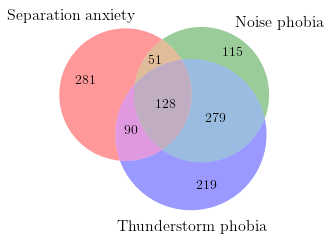

Chi-squared Test of Independence for Thunderstorm phobia, Noise phobia, and Separation anxiety:
chi2 = 285.272663, p = 1.53E-61, dof = 3
The resulting p-value is below the set significance threshold (0.01).


In [75]:
# Create a contingency table.
labels = ['Thunderstorm phobia', 'Noise phobia', 'Separation anxiety']
contingency = pd.crosstab(df[labels[2]], [df[labels[0]], df[labels[1]]])

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[2]: contingency[0][0][1],
     labels[1]: contingency[1][0][0],
     'Separation-Noise': contingency[1][0][1],
     labels[0]: contingency[0][1][0],
     'Separation-Thunderstorm': contingency[0][1][1],
     'Noise-Thunderstorm': contingency[1][1][0],     
     'All': contingency[1][1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
v = venn3(cross_sums, set_labels=[cross_sums.index.values[i] for i in [0, 1, 3]])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x+0.25, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_1')
plt.show()

# Execute a chi-squared test of independence.
print('Chi-squared Test of Independence for %s, %s, and %s:' %(labels[0], labels[1], labels[2]))
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)

## 6. Compulsion and Fearful/Anxious Behaviors

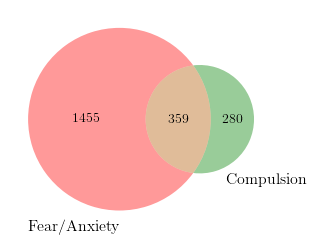

Chi-square Test of Independence:
chi2 = 44.843203, p = 2.13E-11, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [76]:
# Create the necessary dataframe.
fields = 'q02_main_2, q02_main_3'
labels = ['Fear/Anxiety', 'Compulsion']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

# Cross tabulate the relevant columns.
contingency = pd.crosstab(df[labels[0]], df[labels[1]])

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('B')
x, y = lbl.get_position()
lbl.set_position((x+0.15, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_2')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)

## 7. Aggression and Fearful/Anxious Behavior

### Overall aggression and fearful/anxious behavior:

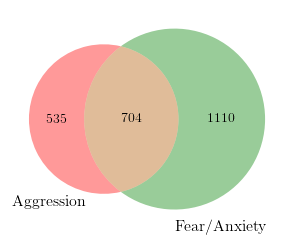

Chi-square Test of Independence:
chi2 = 116.490685, p = 3.71E-27, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [77]:
# Create the necessary dataframe.
fields = 'q02_main_1, q02_main_2'
labels = ['Aggression', 'Fear/Anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]])

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x-0.1, y+0.05))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_3')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)

### Owner directed aggression and fearful/anxious behavior:

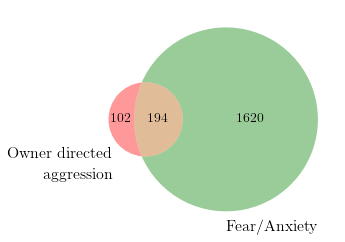

Chi-square Test of Independence:
chi2 = 59.514770, p = 1.21E-14, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [78]:
# Create the necessary dataframe.
fields = 'q03_main_1, q02_main_2'
labels = ['Owner directed\naggression', 'Fear/Anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]])

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
lbl = v.get_label_by_id('A')
x, y = lbl.get_position()
lbl.set_position((x-0.2, y+0.1))
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_4')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)

### 7.3 Owner directed aggression and separation anxiety:

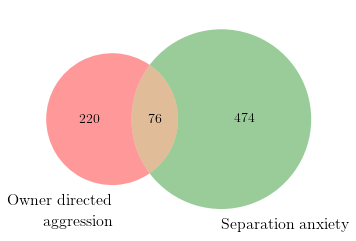

Chi-square Test of Independence:
chi2 = 41.709109, p = 1.06E-10, dof = 1
The resulting p-value is below the set significance threshold (0.01).


In [79]:
# Create the necessary dataframe.
fields = 'q03_main_1, q04_9'
labels = ['Owner directed\naggression', 'Separation anxiety']
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)
    
# Create a contingency table.
contingency = pd.crosstab(df[labels[0]], df[labels[1]])

# Convert the cross tabulated dataframe to a series of sums.
d = {labels[0]: contingency[0][1],
     labels[1]: contingency[1][0],
     'Both': contingency[1][1]}   
cross_sums = pd.Series(d)

# Display the cross tabulated data as a venn diagram.
labels = cross_sums.index.values
v = venn2(cross_sums, set_labels=labels[0:2])
for text in v.set_labels:
    text.set_fontsize(16)
for text in v.subset_labels:
    text.set_fontsize(14)
exportFigure(plt, 'figure_5')
plt.show()

# Execute a chi-squared test of independence.
c, p, dof, expected = scs.chi2_contingency(contingency, correction=False)
print('Chi-square Test of Independence:')
print('chi2 = %f, p = %.2E, dof = %d' %(c, p, dof))
checkSignificance(p)

## 8. Impact of Gender and Neutered Status

### On study prevalence:

This section examines the impact gender and neutered status had on the prevalence among all participating dogs (i.e. the probability of selecting a dog with the specific sex, neutered status, and behavior problem from the entire study population).

Note: \[I\] = intact, \[N\] = neutered

In [80]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(CATEGORY, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.extend(('dog_sex', 'dog_spayed'))
labels.extend(('Gender', 'Neutered'))
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

df_intact_male = df[(df['Gender'] == 1) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_male = df[(df['Gender'] == 1) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])
df_intact_female = df[(df['Gender'] == 2) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_female = df[(df['Gender'] == 2) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])

intact_male_s = df_intact_male.sum()
neutered_male_s = df_neutered_male.sum()
intact_female_s = df_intact_female.sum()
neutered_female_s = df_neutered_female.sum()

intact_male_p = intact_male_s.apply(PREVALENCE)
neutered_male_p = neutered_male_s.apply(PREVALENCE)
intact_female_p = intact_female_s.apply(PREVALENCE)
neutered_female_p = neutered_female_s.apply(PREVALENCE)

# Get individual behavior problem counts and display as a table.
data = [go.Table(columnwidth = [200, 100, 105, 115, 120],
                 header=dict(values=['Behavior Problem', 'Male [I] (%)',
                                     'Male [N] (%)', 'Female [I] (%)',
                                     'Female [N] (%)'],
                             fill = dict(color='#B0C4DE'),
                             align = ['left'] * 5),
                 cells=dict(values=[labels[:-2], intact_male_p.values,
                                    neutered_male_p.values, intact_female_p.values,
                                    neutered_female_p],
                            align = ['left'] * 5,
                            format = [None, '.2f' * 4]))]
layout = go.Layout(title='Impact of Gender and Neutered Status on Study Prevalence',
                   width=740,
                   height=400,
                   margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
if SAVE_OUTPUT:
    py.plot(fig, image='png', image_width=740, image_height=400,
            image_filename='8_1_study_prevalence')
py.iplot(fig)

### On group prevalence:

This section looks at the impact gender and neutered status had on the prevalence among dogs of the same group (i.e. the probability of selecting a dog with the specific sex, neutered status, and behavior problem from the group of the study population that shares the same sex and neutered status).

Note: \[I\] = intact, \[N\] = neutered

In [81]:
# Create the necessary dataframe.
fields = []
labels = []
for counter, cat in enumerate(CATEGORY, 1):
    if counter > 10:
        counter += 1;
    fields.append('q02_main_{}'.format(counter))
    labels.append(cat)   
fields.extend(('dog_sex', 'dog_spayed'))
labels.extend(('Gender', 'Neutered'))
fields = ', '.join(fields)
df = createNumericDataFrame(DOG_TABLE, fields, labels, filtered=True)

df_intact_male = df[(df['Gender'] == 1) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_male = df[(df['Gender'] == 1) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])
df_intact_female = df[(df['Gender'] == 2) & (df['Neutered'] == 0)].drop(
    columns=['Gender', 'Neutered'])
df_neutered_female = df[(df['Gender'] == 2) & (df['Neutered'] == 1)].drop(
    columns=['Gender', 'Neutered'])

intact_male_c = len(df_intact_male.index)
neutered_male_c = len(df_neutered_male.index)
intact_female_c = len(df_intact_female.index)
neutered_female_c = len(df_neutered_female.index)

intact_male_s = df_intact_male.sum()
neutered_male_s = df_neutered_male.sum()
intact_female_s = df_intact_female.sum()
neutered_female_s = df_neutered_female.sum()

intact_male_p = intact_male_s.apply(lambda x: (x / intact_male_c) * 100)
neutered_male_p = neutered_male_s.apply(lambda x: (x / neutered_male_c) * 100)
intact_female_p = intact_female_s.apply(lambda x: (x / intact_female_c) * 100)
neutered_female_p = neutered_female_s.apply(lambda x: (x / neutered_female_c) * 100)

# Get individual behavior problem counts and display as a table.
data = [go.Table(columnwidth = [200, 100, 105, 115, 120],
                 header=dict(values=['Behavior Problem', 'Male [I] (%)',
                                     'Male [N] (%)', 'Female [I] (%)',
                                     'Female [N] (%)'],
                             fill = dict(color='#B0C4DE'),
                             align = ['left'] * 5),
                 cells=dict(values=[labels[:-2], intact_male_p.values,
                                    neutered_male_p.values, intact_female_p.values,
                                    neutered_female_p],
                            align = ['left'] * 5,
                            format = [None, '.2f' * 4]))]
layout = go.Layout(title='Impact of Gender and Neutered Status on Group Prevalence',
                   width=740,
                   height=400,
                   margin=go.Margin(l=50, r=50, b=50, t=50, pad=4))
fig = dict(data=data, layout=layout)
if SAVE_OUTPUT:
    py.plot(fig, image='png', image_width=740, image_height=400,
            image_filename='8_2_group_prevalence')
py.iplot(fig)

## 9. Patterns in Behavior Problem Frequency

### Impact of gender on behavior problem frequency:

In [82]:
# status: unverified
fields = 'q02_score, dog_sex'
labels = ['number of behavior problems', 'gender']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
replacements = {'1':'male', '2':'female'}
replaceFields(df, labels[1], replacements)
display(pd.crosstab(df[labels[0]], df[labels[1]], margins=True))

gender,female,male,All
number of behavior problems,,,
0,331,268,599
1,544,510,1054
10,2,3,5
11,0,2,2
12,0,1,1
2,455,457,912
3,322,333,655
4,200,214,414
5,121,96,217


### Impact of neutered status on behavior problem frequency:

In [83]:
# status: unverified
fields = 'q02_score, dog_spayed'
labels = ['number of behavior problems', 'neutered']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[1]] != '']
df = df[df[labels[1]] != '2']
replacements = {'0':'no', '1':'yes'}
replaceFields(df, labels[1], replacements)
display(pd.crosstab(df[labels[0]], df[labels[1]], margins=True))

neutered,no,yes,All
number of behavior problems,,,
0,139,458,597
1,200,853,1053
10,1,4,5
11,0,2,2
12,0,1,1
2,125,784,909
3,73,583,656
4,44,368,412
5,14,203,217


### Impact of source of origin on behavior problem frequency:

In [84]:
# status: unverified
fields = 'q02_score, acquisition_source'
labels = ['number of behavior problems', 'origin']
df = createStringDataFrame(DOG_TABLE, fields, labels)
# Rescue fields (online: 1, in-person: 4) were combined in the database.
replacements = {'':'no response', '1': 'rescue', '2': 'online (non-rescue)', '3': 'pet store', '5': 'breeder',
                '6': 'self-bred', '7': 'friends/family', '8': 'found', '9': 'other'}
replaceFields(df, labels[1], replacements)
display(pd.crosstab(df[labels[0]], df[labels[1]], margins=True))

origin,breeder,found,friends/family,no response,online (non-rescue),other,pet store,rescue,self-bred,All
number of behavior problems,,,,,,,,,,
0,298,14,46,7,6,36,4,146,45,602
1,387,29,84,9,17,51,12,418,51,1058
10,3,0,0,0,0,0,0,2,0,5
11,1,0,0,0,0,0,0,1,0,2
12,0,0,0,0,0,1,0,0,0,1
2,290,22,66,6,9,64,10,418,27,912
3,171,21,64,4,18,34,7,332,8,659
4,96,13,42,5,13,12,7,225,3,416
5,48,7,21,0,6,12,7,116,1,218


### Impact of purebred status on behavior problem frequency:

In [85]:
# status: unverified
fields = 'q02_score, purebred'
labels = ['number of behavior problems', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
replacements = {'0':'no', '1':'yes'}
df = df[df[labels[1]] != '']
replaceFields(df, labels[1], replacements)
display(pd.crosstab(df[labels[0]], df[labels[1]], margins=True))

purebred,no,yes,All
number of behavior problems,,,
0,143,447,590
1,412,631,1043
10,1,4,5
11,1,1,2
12,0,1,1
2,388,513,901
3,320,331,651
4,206,204,410
5,110,105,215


### Impact of behavior problem suspicion on behavior problem frequency:

In [86]:
# status: verified
# Create the necessary dataframe.
fields = 'q02_score, purebred_breed, purebred'
labels = ['number of behavior problems', 'breed', 'purebred']
df = createStringDataFrame(DOG_TABLE, fields, labels)
df = df[df[labels[2]] == '1']
df.drop(columns=labels[2], inplace=True)
df = df[df[labels[1]] != '']
display(pd.crosstab(df[labels[0]], df[labels[1]], margins=True))

breed,affenpinscher,afghan hound,airedale terrier,akita,alaskan malamute,american eskimo dog,american staffordshire terrier,american water spaniel,australian cattle dog,australian shepherd,...,weimaraner,welsh springer spaniel,welsh terrier,west highland white terrier,whippet,wire fox terrier,wirehaired pointing griffon,wirehaired vizsla,yorkshire terrier,All
number of behavior problems,,,,,,,,,,,,,,,,,,,,,
0,0,1,3,2,0,0,1,0,1,10,...,1,0,1,3,1,0,0,2,4,415
1,3,0,4,2,1,0,2,0,6,17,...,4,0,2,4,3,2,0,1,7,572
10,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,4
11,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
12,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,0,0,2,2,0,0,4,0,5,6,...,2,1,1,10,4,0,1,1,7,463
3,0,0,0,2,2,1,8,1,2,9,...,1,0,0,2,3,0,1,0,3,308
4,0,1,0,0,2,0,1,0,4,10,...,2,0,1,0,1,0,0,0,1,189
5,0,0,1,0,0,0,0,0,0,4,...,1,0,0,0,0,1,0,0,2,94


## 10. Heatmaps

### Category reference chart:

In [87]:
# Construct lists.
cat_dict = {}
for cat, subdict in FR.labels.items():
    for key, value in  subdict.items():
        cat_dict[key[0]] = cat
        break

s = pd.Series(cat_dict)
df = pd.DataFrame(index=s.index, data={'Category':s.values})
df.columns.name = 'Index'
display(df)
exportTable(df, 'table_category_reference')

Index,Category
A,Aggression
B,Fear/Anxiety
C,Compulsion
D,House Soiling
E,Excessive Barking
F,Jumping
G,Mounting/Humping
H,Consuming Feces
I,Destructive Behavior
J,Rolling in Repulsive Material


### Category heatmap:

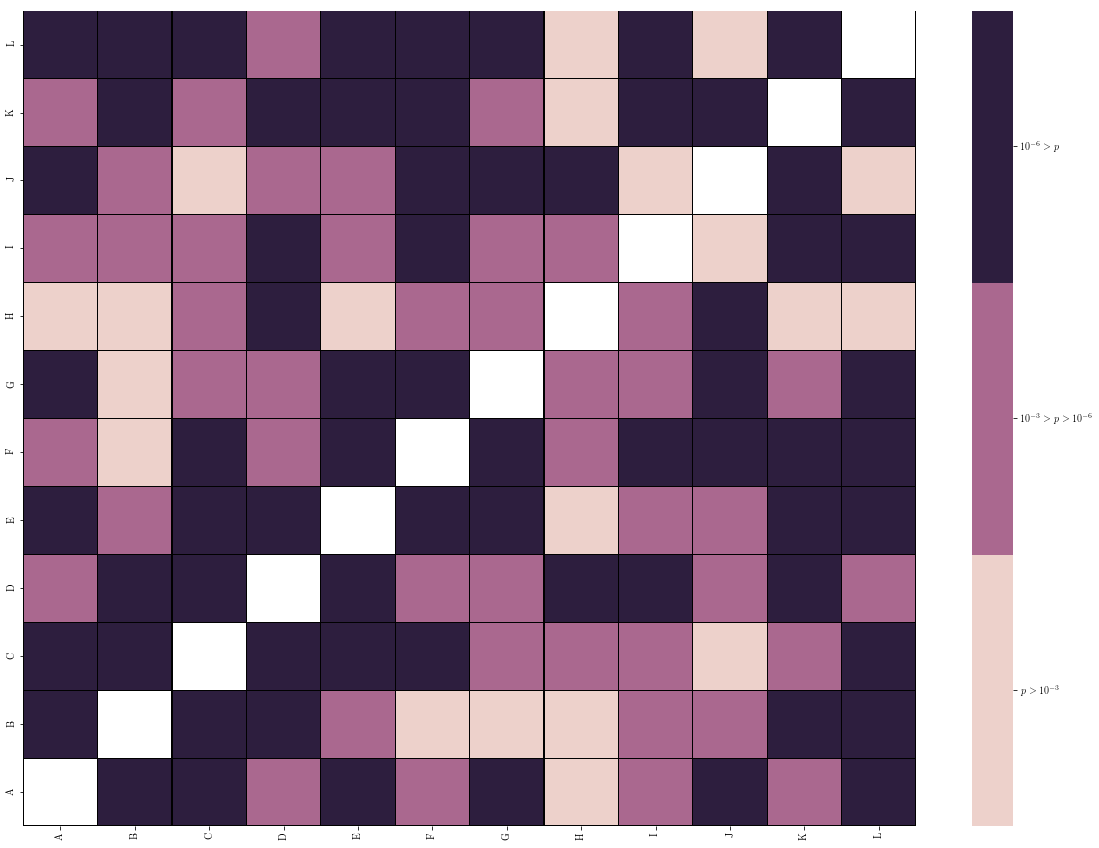

In [88]:
if CATEGORY_MATRIX.empty:
    CATEGORY_MATRIX = createCategoryMatrix()
    
# Create a new dataframe with categories:
df = CATEGORY_MATRIX.applymap(lambda row: get_significance_category(row))

# Heatmap
fig, ax = plt.subplots(figsize=(20, 15))
cmap = sns.cubehelix_palette(n_colors=3)
ax = sns.heatmap(data=df, ax=ax, cmap=ListedColormap(cmap), linewidths=.008, linecolor='black',
                 cbar_kws={'orientation': 'vertical'}, mask=df.isnull())
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['$p>10^{-3}$', '$10^{-3}>p>10^{-6}$', '$10^{-6}>p$'])
plt.xticks(rotation=90)
ax.invert_yaxis()
exportFigure(fig, 'figure_6')
plt.show()

### Questionnaire reference chart:

In [89]:
# Construct lists.
locs = []
responses = []
categories = []
for cat, subdict in FR.labels.items():
    for key, value in  subdict.items():
        locs.append(key)
        responses.append(value)
        categories.append(cat)

df = pd.DataFrame(index=locs, data={'Category': categories, 'Response': responses})
df.columns.name = 'Index'
display(df)
exportTable(df, 'table_questionnaire_reference')

Index,Category,Response
A01,Aggression,Familiar people in the home
A02,Aggression,Stangers visiting the home
A03,Aggression,Stangers away from the home
A04,Aggression,Another dog in the home
A05,Aggression,Unfamiliar dogs visiting the home
A06,Aggression,Unfamiliar dogs on walks (off lead)
A07,Aggression,Unfamiliar dogs on walks (on lead)
A08,Aggression,Veterinarians
A09,Aggression,Trainers
A10,Aggression,Groomers


### Questionnaire heatmap:

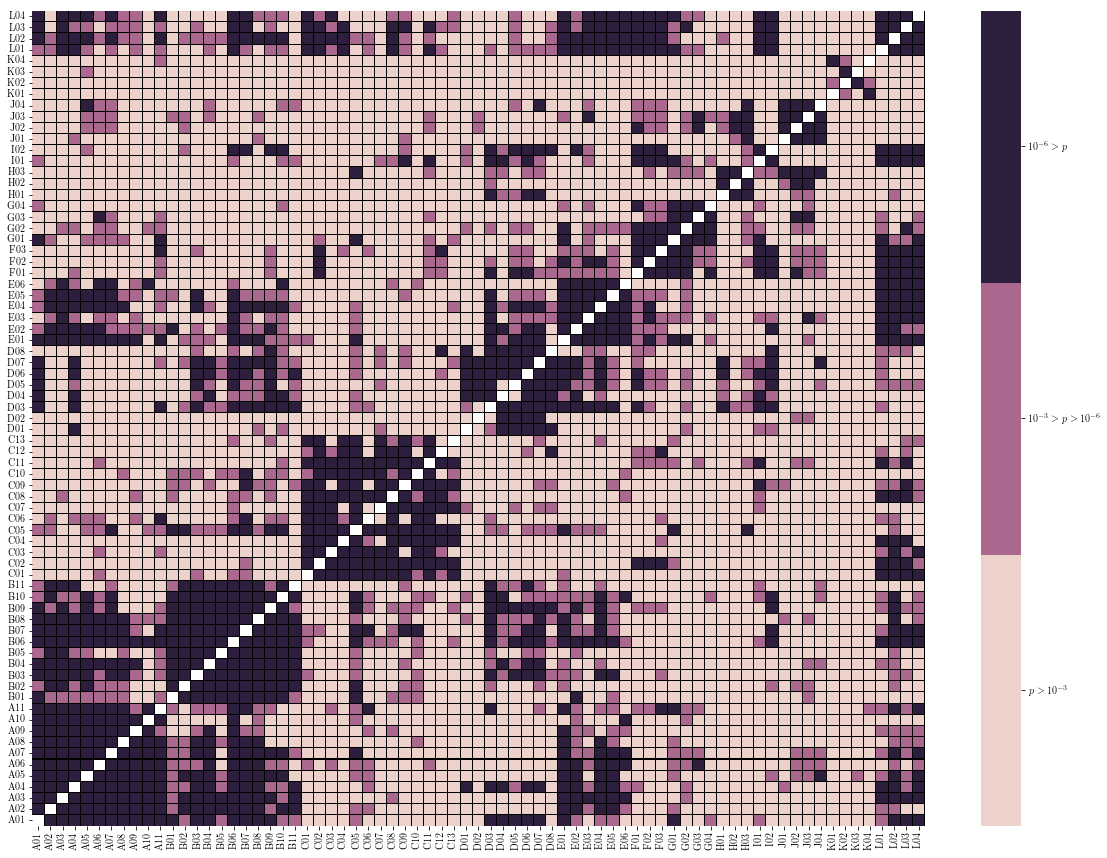

In [90]:
if QUESTION_MATRIX.empty:
    QUESTION_MATRIX = createQuestionMatrix()
    
# Create a new dataframe with categories:
df = QUESTION_MATRIX.applymap(lambda row: get_significance_category(row))

# Heatmap
fig, ax = plt.subplots(figsize=(20, 15))
cmap = sns.cubehelix_palette(n_colors=3)
ax = sns.heatmap(data=df, ax=ax, cmap=ListedColormap(cmap), linewidths=.008, linecolor='black',
                 cbar_kws={'orientation': 'vertical'}, mask=df.isnull())
colorbar = ax.collections[0].colorbar
colorbar.set_ticks([-0.667, 0, 0.667])
colorbar.set_ticklabels(['$p>10^{-3}$', '$10^{-3}>p>10^{-6}$', '$10^{-6}>p$'])
plt.xticks(rotation=90)
ax.invert_yaxis()
exportFigure(fig, 'figure_7')
plt.show()